In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8 # assert sum to 1.0
    positive=0
    # 0 - suma  
    # 1 - no suma
    # 10 suma
    # 11 no suma
    # 100 suma
    # 101 no suma
    # suma la probabilidad de todos los bitstrings pares,
    # en otras palabras, la probabilidad de que el qubit 0 sea 0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(3,20):
        assert counter[i]==0
        
    return counter

In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

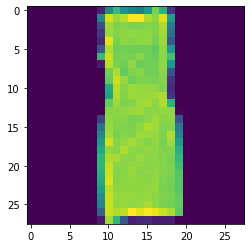

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

In [4]:
#your submission

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    q = qiskit.QuantumRegister(3)
    circuit = qiskit.QuantumCircuit(q)
    if image[0][0]==0:
        circuit.rx(np.pi,0)
    return circuit


def run_part2(image):

    #loade the quantum classifier circuit
    classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    #encode image into circuit
    circuit=encode(image)
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)
        
    return circuit,label
#score

In [5]:
#how we grade your submission

score=0
gatecount=0
n=len(dataset)

for data in dataset:
    #run part 2
    circuit,label=run_part2(data['image'])
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

0.0


In [13]:
from qiskit import QuantumCircuit
from sklearn.decomposition import PCA

#your submission

N_QUBITS_AMPLITUDE_ENCODING = 8

# Functions 'encode' and 'decode' are dummy.
def encode_amplitude(image, debug=False):
    # We have 28x28 images as input
    # - we can do amplitude encoding of a normalized amplitude vector that has size of 2 ** n (full power of two)
    # 28 x 28 = 784 doesn't fit into a full power of two, so we use PCA to reduce the dimensionality to fit it 
    # into n_qubits (parametrized)
    
    min_ = image.min()

    image_pca = image - min_
    
    # [normalize]
    def normalize(row):
        #We calculate the squareroot of the sum of the square values of the row
        normalization_factor = np.sqrt(np.sum(row**2)) 
        if normalization_factor == 0.:
            #If the sum is zero we return a 0
            return 0.0
        #Else we divide each value between the sum value above
        row = row / normalization_factor
        return row, normalization_factor
    
    image_pca_normalized, normalization_factor = normalize(image_pca)
    
    desired_state = image_pca_normalized
    
    ##########
    # Amplitude Encoding
    qc = QuantumCircuit(N_QUBITS_AMPLITUDE_ENCODING)
    qc.initialize(desired_state)
    qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()

    ##########
    
    decoder_params = dict(
        min_=min_,
        normalization_factor=normalization_factor,
        n_qubits=n_qubits,
        image=image
    )
    
    return qc_decomposed, decoder_params

def run_part2(image):

    #loade the quantum classifier circuit
    classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    #encode image into circuit
    circuit, _ = encode_amplitude(image)
    
    #append with classifier circuit
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)
        
    return circuit,label
#score

In [10]:
encode_amplitude

<function __main__.encode_amplitude(image, debug=False)>

In [15]:
#how we grade your submission

score=0
gatecount=0
n=len(dataset)

for data in dataset:
    #run part 2
    circuit,label=run_part2(data['image'])
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

AttributeError: 'list' object has no attribute 'min'

In [38]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(1)
#qc.x(0)

a = qc.qasm(filename="quantum_classifier.qasm")

In [39]:
!ls

 data				       part1_example_qiskit.ipynb
 data1.json			       part1.py
 data2.json			       part2_example_cirq.ipynb
 examples.ipynb			       part2_example_qiskit-Copy1.ipynb
 examples_qiskit.ipynb		       part2_example_qiskit.ipynb
'MIT iQuHACK remote challenge .docx'   part2.pickle
 MIT_iQuHACK_remote_challenge.pdf      part2.qasm
 mock_data			       __pycache__
 mock_data_creator.ipynb	       quantum_classifier.qasm
 part1_example_cirq.ipynb	       README.md
 part1_example_qiskit-Copy1.ipynb


In [ ]:
# versioned classifer

In [122]:
classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')

In [123]:
classifier.draw()

q:

In [ ]:
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import tqdm
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import algorithm_globals


from scipy.optimize import minimize 


def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

#Function to identify a function cost
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Function cost
'''

def objective_function(params, images, labels, shots=1024, mini_batch=5, n_qubits=8):

    running_loss = 0

    images, labels = shuffle(images, labels)
    
    y_pred = []

    #For each item of the trainig set
    for i in tqdm.tqdm(range(mini_batch)):
        
        image = images[i]
        
        circuit, _ = encode_amplitude(image) #Create a inicial circuit
        vqc = ansatz(n_qubits)

        vqc = vqc.assign_parameters(params)

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n_qubits)
    
        qubits = list(range(n_qubits))
        
        circuit_full.append(circuit.to_instruction(), qubits)
        circuit_full.append(vqc.to_instruction(), qubits)

        #Combine the initial circuit, the quantum variatinal circuit and the swap test
        #For the initial circuit and QVC we start at the qubit size_reduce + 1
        
        #Execute the circuit in the qasm_simulator
        histogram = simulate(circuit_full)

        pred_label = histogram_to_category(histogram)
        
        #print(histogram)
        print("Pred label")
        print(pred_label, labels[i])
        
        y_pred.append(pred_label)
    
    print(labels.shape)
    
    print(len(y_pred))
    y_true = labels[:mini_batch].astype(int)
    
    

    loss = log_loss(y_true, y_pred, labels=[0, 1])
    
    print(y_true, y_pred)
    print("Loss")
    print(loss)
    

    return loss

N_images = len(images)    
n_qubits = 8
shots = 1024
mini_batch = 25

vqc = ansatz(n_qubits)
np.random.seed(42)
initial_point = algorithm_globals.random.random(vqc.num_parameters)

pca = PCA(n_components=2**N_QUBITS_AMPLITUDE_ENCODING)

# Fit PCA on your 784-dimensional data
data = images.reshape(N_images, 28 * 28)
pca.fit(data)

# Apply dimensionality reduction on your data
images_pca = pca.transform(data)


for i in range(1):
    #Minimization of the objective_fucntion by a COBYLA method
    minimum = minimize(objective_function, 
                       initial_point, 
                       args=(images_pca, labels, shots, mini_batch, n_qubits), 
                       method='COBYLA', 
                       tol=1e-6,
                       options={
                           "maxiter": 100
                       }
                      )
    params = minimum.x #Get the solution array
    #Show the cost of the solution array
    print("Cost: ", objective_function(params))
    print(params)

  4%|▍         | 1/25 [00:03<01:24,  3.50s/it]

Pred label
0.22439816871034923 False


  8%|▊         | 2/25 [00:07<01:20,  3.51s/it]

Pred label
0.21170995251224078 True


 12%|█▏        | 3/25 [00:10<01:17,  3.54s/it]

Pred label
0.20662628224997392 False


 16%|█▌        | 4/25 [00:14<01:14,  3.54s/it]

Pred label
0.25445433121633726 False


 20%|██        | 5/25 [00:17<01:10,  3.54s/it]

Pred label
0.20667354912605257 False


 24%|██▍       | 6/25 [00:21<01:07,  3.53s/it]

Pred label
0.1897896296762502 False


 28%|██▊       | 7/25 [00:24<01:03,  3.52s/it]

Pred label
0.2057015746555031 False


 32%|███▏      | 8/25 [00:28<00:59,  3.52s/it]

Pred label
0.20449671568497396 True


 36%|███▌      | 9/25 [00:31<00:56,  3.51s/it]

Pred label
0.24551086370310526 False


 40%|████      | 10/25 [00:35<00:52,  3.52s/it]

Pred label
0.2074080983684203 False


 44%|████▍     | 11/25 [00:38<00:49,  3.52s/it]

Pred label
0.21582851207990894 False


 48%|████▊     | 12/25 [00:42<00:45,  3.52s/it]

Pred label
0.22654322634275184 False


 52%|█████▏    | 13/25 [00:45<00:42,  3.52s/it]

Pred label
0.18209408638661978 True


 56%|█████▌    | 14/25 [00:49<00:38,  3.54s/it]

Pred label
0.20240314267513765 True


 60%|██████    | 15/25 [00:52<00:35,  3.54s/it]

Pred label
0.22936205445425328 False


 64%|██████▍   | 16/25 [00:56<00:31,  3.54s/it]

Pred label
0.2699754101286921 False


 68%|██████▊   | 17/25 [00:59<00:28,  3.54s/it]

Pred label
0.21295420601122067 False


 72%|███████▏  | 18/25 [01:03<00:24,  3.52s/it]

Pred label
0.25320741377365946 False


 76%|███████▌  | 19/25 [01:06<00:21,  3.52s/it]

Pred label
0.25027978164215253 False


 80%|████████  | 20/25 [01:10<00:17,  3.52s/it]

Pred label
0.21812988323654317 False


 84%|████████▍ | 21/25 [01:13<00:14,  3.51s/it]

Pred label
0.21376971638099182 True


 88%|████████▊ | 22/25 [01:17<00:10,  3.51s/it]

Pred label
0.21527802698413995 False


 92%|█████████▏| 23/25 [01:21<00:07,  3.51s/it]

Pred label
0.21257775126821837 True


 96%|█████████▌| 24/25 [01:24<00:03,  3.53s/it]

Pred label
0.2108350723040899 False


100%|██████████| 25/25 [01:28<00:00,  3.53s/it]


Pred label
0.2175567325846446 False
(2000,)
25
[0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0] [0.22439816871034923, 0.21170995251224078, 0.20662628224997392, 0.25445433121633726, 0.20667354912605257, 0.1897896296762502, 0.2057015746555031, 0.20449671568497396, 0.24551086370310526, 0.2074080983684203, 0.21582851207990894, 0.22654322634275184, 0.18209408638661978, 0.20240314267513765, 0.22936205445425328, 0.2699754101286921, 0.21295420601122067, 0.25320741377365946, 0.25027978164215253, 0.21812988323654317, 0.21376971638099182, 0.21527802698413995, 0.21257775126821837, 0.2108350723040899, 0.2175567325846446]
Loss
0.5745100031491128


  4%|▍         | 1/25 [00:03<01:23,  3.49s/it]

Pred label
0.256399222775756 False


  8%|▊         | 2/25 [00:07<01:21,  3.52s/it]

Pred label
0.2522511254583919 False


 12%|█▏        | 3/25 [00:10<01:17,  3.52s/it]

Pred label
0.22699886538358147 True


 16%|█▌        | 4/25 [00:14<01:14,  3.54s/it]

Pred label
0.27895830430144714 False


 20%|██        | 5/25 [00:17<01:10,  3.54s/it]

Pred label
0.27200285489720577 True


 24%|██▍       | 6/25 [00:21<01:07,  3.54s/it]

Pred label
0.2729102581282131 False


 28%|██▊       | 7/25 [00:24<01:04,  3.56s/it]

Pred label
0.2595648491949362 True


 32%|███▏      | 8/25 [00:28<01:00,  3.58s/it]

Pred label
0.29628643240883934 False


 36%|███▌      | 9/25 [00:31<00:57,  3.58s/it]

Pred label
0.29554996814920703 True


 40%|████      | 10/25 [00:35<00:53,  3.57s/it]

Pred label
0.26960990182632666 True


 44%|████▍     | 11/25 [00:39<00:49,  3.56s/it]

Pred label
0.27770201252810756 False


 48%|████▊     | 12/25 [00:42<00:46,  3.56s/it]

Pred label
0.3014902258350622 False


 52%|█████▏    | 13/25 [00:46<00:42,  3.55s/it]

Pred label
0.2395650310981694 True


 56%|█████▌    | 14/25 [00:49<00:39,  3.55s/it]

Pred label
0.23872871330654108 True


 60%|██████    | 15/25 [00:53<00:35,  3.54s/it]

Pred label
0.28355292140538935 False


 64%|██████▍   | 16/25 [00:56<00:31,  3.54s/it]

Pred label
0.28880802552904417 True


 68%|██████▊   | 17/25 [01:00<00:28,  3.55s/it]

Pred label
0.29439435327977337 True


 72%|███████▏  | 18/25 [01:03<00:24,  3.54s/it]

Pred label
0.2884215729214027 False


 76%|███████▌  | 19/25 [01:07<00:21,  3.55s/it]

Pred label
0.26214237472350965 False


 80%|████████  | 20/25 [01:10<00:17,  3.53s/it]

Pred label
0.2535764189529114 False


 84%|████████▍ | 21/25 [01:14<00:14,  3.54s/it]

Pred label
0.2922011621858887 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.55s/it]

Pred label
0.2300621753768395 False


 92%|█████████▏| 23/25 [01:21<00:07,  3.56s/it]

Pred label
0.2985209362922094 True


 96%|█████████▌| 24/25 [01:25<00:03,  3.56s/it]

Pred label
0.26980845445291735 False


100%|██████████| 25/25 [01:28<00:00,  3.55s/it]


Pred label
0.2229926576056259 False
(2000,)
25
[0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0] [0.256399222775756, 0.2522511254583919, 0.22699886538358147, 0.27895830430144714, 0.27200285489720577, 0.2729102581282131, 0.2595648491949362, 0.29628643240883934, 0.29554996814920703, 0.26960990182632666, 0.27770201252810756, 0.3014902258350622, 0.2395650310981694, 0.23872871330654108, 0.28355292140538935, 0.28880802552904417, 0.29439435327977337, 0.2884215729214027, 0.26214237472350965, 0.2535764189529114, 0.2922011621858887, 0.2300621753768395, 0.2985209362922094, 0.26980845445291735, 0.2229926576056259]
Loss
0.7164196534818487


  4%|▍         | 1/25 [00:03<01:24,  3.52s/it]

Pred label
0.17181826212888904 False


  8%|▊         | 2/25 [00:07<01:21,  3.54s/it]

Pred label
0.16375452807056995 False


 12%|█▏        | 3/25 [00:10<01:18,  3.56s/it]

Pred label
0.21299900819965478 True


 16%|█▌        | 4/25 [00:14<01:14,  3.55s/it]

Pred label
0.2278272620860801 False


 20%|██        | 5/25 [00:17<01:11,  3.56s/it]

Pred label
0.1888169279222505 False


 24%|██▍       | 6/25 [00:21<01:06,  3.52s/it]

Pred label
0.2482197101809898 True


 28%|██▊       | 7/25 [00:24<01:03,  3.54s/it]

Pred label
0.15542771450935472 False


 32%|███▏      | 8/25 [00:28<01:00,  3.56s/it]

Pred label
0.20114162179223788 False


 36%|███▌      | 9/25 [00:31<00:57,  3.57s/it]

Pred label
0.17532790267608767 True


 40%|████      | 10/25 [00:35<00:53,  3.57s/it]

Pred label
0.15710178726073862 False


 44%|████▍     | 11/25 [00:39<00:50,  3.57s/it]

Pred label
0.19105020575020518 False


 48%|████▊     | 12/25 [00:42<00:46,  3.57s/it]

Pred label
0.20259934003924285 False


 52%|█████▏    | 13/25 [00:46<00:42,  3.57s/it]

Pred label
0.18765566460928884 True


 56%|█████▌    | 14/25 [00:49<00:39,  3.55s/it]

Pred label
0.1868390840132907 False


 60%|██████    | 15/25 [00:53<00:35,  3.56s/it]

Pred label
0.13791001881349174 False


 64%|██████▍   | 16/25 [00:56<00:31,  3.55s/it]

Pred label
0.17835326918675837 True


 68%|██████▊   | 17/25 [01:00<00:28,  3.56s/it]

Pred label
0.17357667472036098 False


 72%|███████▏  | 18/25 [01:03<00:24,  3.55s/it]

Pred label
0.17734696981974893 True


 76%|███████▌  | 19/25 [01:07<00:21,  3.53s/it]

Pred label
0.16400438270433337 False


 80%|████████  | 20/25 [01:10<00:17,  3.53s/it]

Pred label
0.16547798793189464 False


 84%|████████▍ | 21/25 [01:14<00:14,  3.54s/it]

Pred label
0.20236448913447921 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.57s/it]

Pred label
0.17004337263866906 True


 92%|█████████▏| 23/25 [01:21<00:07,  3.57s/it]

Pred label
0.1759592510663209 True


 96%|█████████▌| 24/25 [01:25<00:03,  3.55s/it]

Pred label
0.19861226650606195 False


100%|██████████| 25/25 [01:28<00:00,  3.55s/it]


Pred label
0.20867643215519466 True
(2000,)
25
[0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1] [0.17181826212888904, 0.16375452807056995, 0.21299900819965478, 0.2278272620860801, 0.1888169279222505, 0.2482197101809898, 0.15542771450935472, 0.20114162179223788, 0.17532790267608767, 0.15710178726073862, 0.19105020575020518, 0.20259934003924285, 0.18765566460928884, 0.1868390840132907, 0.13791001881349174, 0.17835326918675837, 0.17357667472036098, 0.17734696981974893, 0.16400438270433337, 0.16547798793189464, 0.20236448913447921, 0.17004337263866906, 0.1759592510663209, 0.19861226650606195, 0.20867643215519466]
Loss
0.7230144877578292


  4%|▍         | 1/25 [00:03<01:25,  3.55s/it]

Pred label
0.2849321652383916 False


  8%|▊         | 2/25 [00:07<01:21,  3.56s/it]

Pred label
0.20286386878482496 False


 12%|█▏        | 3/25 [00:10<01:18,  3.59s/it]

Pred label
0.18633902093218147 True


 16%|█▌        | 4/25 [00:14<01:15,  3.60s/it]

Pred label
0.21053467487391994 False


 20%|██        | 5/25 [00:17<01:11,  3.59s/it]

Pred label
0.18639975433484018 True


 24%|██▍       | 6/25 [00:21<01:08,  3.59s/it]

Pred label
0.2502934372689309 False


 28%|██▊       | 7/25 [00:25<01:04,  3.59s/it]

Pred label
0.21012390184504182 False


 32%|███▏      | 8/25 [00:28<01:01,  3.59s/it]

Pred label
0.2284541316446929 False


 36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

Pred label
0.19507123612580993 False


 40%|████      | 10/25 [00:35<00:53,  3.60s/it]

Pred label
0.1811484501087359 False


 44%|████▍     | 11/25 [00:39<00:50,  3.60s/it]

Pred label
0.21189159271689423 False


 48%|████▊     | 12/25 [00:43<00:46,  3.57s/it]

Pred label
0.21149326487536751 False


 52%|█████▏    | 13/25 [00:46<00:43,  3.58s/it]

Pred label
0.2190143224736442 False


 56%|█████▌    | 14/25 [00:50<00:39,  3.59s/it]

Pred label
0.1915135358184522 True


 60%|██████    | 15/25 [00:53<00:35,  3.59s/it]

Pred label
0.19504081439113843 False


 64%|██████▍   | 16/25 [00:57<00:32,  3.59s/it]

Pred label
0.17308093631776605 True


 68%|██████▊   | 17/25 [01:00<00:28,  3.56s/it]

Pred label
0.19591618595711896 False


 72%|███████▏  | 18/25 [01:04<00:25,  3.57s/it]

Pred label
0.2039485232365668 False


 76%|███████▌  | 19/25 [01:08<00:21,  3.58s/it]

Pred label
0.20780633132527676 False


 80%|████████  | 20/25 [01:11<00:17,  3.59s/it]

Pred label
0.2152011273941204 True


 84%|████████▍ | 21/25 [01:15<00:14,  3.59s/it]

Pred label
0.20830135308769465 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.59s/it]

Pred label
0.21717094696311115 False


 92%|█████████▏| 23/25 [01:22<00:07,  3.60s/it]

Pred label
0.2037701141327782 False


 96%|█████████▌| 24/25 [01:26<00:03,  3.62s/it]

Pred label
0.23457062507336532 False


100%|██████████| 25/25 [01:29<00:00,  3.59s/it]


Pred label
0.1871634794348724 False
(2000,)
25
[0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0] [0.2849321652383916, 0.20286386878482496, 0.18633902093218147, 0.21053467487391994, 0.18639975433484018, 0.2502934372689309, 0.21012390184504182, 0.2284541316446929, 0.19507123612580993, 0.1811484501087359, 0.21189159271689423, 0.21149326487536751, 0.2190143224736442, 0.1915135358184522, 0.19504081439113843, 0.17308093631776605, 0.19591618595711896, 0.2039485232365668, 0.20780633132527676, 0.2152011273941204, 0.20830135308769465, 0.21717094696311115, 0.2037701141327782, 0.23457062507336532, 0.1871634794348724]
Loss
0.5240604799152201


  4%|▍         | 1/25 [00:03<01:24,  3.50s/it]

Pred label
0.16283109679980393 True


  8%|▊         | 2/25 [00:07<01:21,  3.53s/it]

Pred label
0.17946315734416562 False


 12%|█▏        | 3/25 [00:10<01:18,  3.57s/it]

Pred label
0.17902537717587483 False


 16%|█▌        | 4/25 [00:14<01:14,  3.57s/it]

Pred label
0.177927062148211 False


 20%|██        | 5/25 [00:17<01:11,  3.58s/it]

Pred label
0.17831548679953227 False


 24%|██▍       | 6/25 [00:21<01:07,  3.56s/it]

Pred label
0.17890148831251332 False


 28%|██▊       | 7/25 [00:24<01:04,  3.57s/it]

Pred label
0.15666123233254392 False


 32%|███▏      | 8/25 [00:28<01:00,  3.58s/it]

Pred label
0.17031083698047703 False


 36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

Pred label
0.17693175281842033 False


 40%|████      | 10/25 [00:35<00:53,  3.59s/it]

Pred label
0.17322400363874468 True


 44%|████▍     | 11/25 [00:39<00:50,  3.59s/it]

Pred label
0.16535205548915363 False


 48%|████▊     | 12/25 [00:42<00:46,  3.59s/it]

Pred label
0.17397100045416 True


 52%|█████▏    | 13/25 [00:46<00:43,  3.60s/it]

Pred label
0.1711366132497 False


 56%|█████▌    | 14/25 [00:50<00:39,  3.59s/it]

Pred label
0.1629396067087388 False


 60%|██████    | 15/25 [00:53<00:35,  3.59s/it]

Pred label
0.18534608849343184 False


 64%|██████▍   | 16/25 [00:57<00:32,  3.58s/it]

Pred label
0.18196742487737852 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.58s/it]

Pred label
0.17560770823374847 False


 72%|███████▏  | 18/25 [01:04<00:25,  3.58s/it]

Pred label
0.1800520829574006 True


 76%|███████▌  | 19/25 [01:08<00:21,  3.58s/it]

Pred label
0.2292491724142283 False


 80%|████████  | 20/25 [01:11<00:17,  3.57s/it]

Pred label
0.17924235043058903 False


 84%|████████▍ | 21/25 [01:15<00:14,  3.58s/it]

Pred label
0.15916901609947576 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.58s/it]

Pred label
0.23686523193568162 False


 92%|█████████▏| 23/25 [01:22<00:07,  3.58s/it]

Pred label
0.17340951170801105 False


 96%|█████████▌| 24/25 [01:25<00:03,  3.58s/it]

Pred label
0.17351662940742563 False


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


Pred label
0.17709241668022432 False
(2000,)
25
[1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0] [0.16283109679980393, 0.17946315734416562, 0.17902537717587483, 0.177927062148211, 0.17831548679953227, 0.17890148831251332, 0.15666123233254392, 0.17031083698047703, 0.17693175281842033, 0.17322400363874468, 0.16535205548915363, 0.17397100045416, 0.1711366132497, 0.1629396067087388, 0.18534608849343184, 0.18196742487737852, 0.17560770823374847, 0.1800520829574006, 0.2292491724142283, 0.17924235043058903, 0.15916901609947576, 0.23686523193568162, 0.17340951170801105, 0.17351662940742563, 0.17709241668022432]
Loss
0.44762737596139124


  4%|▍         | 1/25 [00:03<01:24,  3.53s/it]

Pred label
0.19027154262146928 False


  8%|▊         | 2/25 [00:07<01:21,  3.55s/it]

Pred label
0.20962204236631773 True


 12%|█▏        | 3/25 [00:10<01:18,  3.55s/it]

Pred label
0.28177562288287994 False


 16%|█▌        | 4/25 [00:14<01:14,  3.54s/it]

Pred label
0.19151212284865304 False


 20%|██        | 5/25 [00:17<01:11,  3.55s/it]

Pred label
0.24613075884950736 False


 24%|██▍       | 6/25 [00:21<01:06,  3.52s/it]

Pred label
0.19238845205677335 False


 28%|██▊       | 7/25 [00:24<01:03,  3.54s/it]

Pred label
0.26809120605832 False


 32%|███▏      | 8/25 [00:28<01:00,  3.56s/it]

Pred label
0.20421675819551724 False


 36%|███▌      | 9/25 [00:31<00:56,  3.56s/it]

Pred label
0.20163202738124741 False


 40%|████      | 10/25 [00:35<00:53,  3.55s/it]

Pred label
0.24085412614856774 False


 44%|████▍     | 11/25 [00:39<00:49,  3.55s/it]

Pred label
0.1999475968263486 False


 48%|████▊     | 12/25 [00:42<00:46,  3.56s/it]

Pred label
0.20513585840580348 False


 52%|█████▏    | 13/25 [00:46<00:42,  3.56s/it]

Pred label
0.19699425811936974 False


 56%|█████▌    | 14/25 [00:49<00:39,  3.55s/it]

Pred label
0.20589457314655998 False


 60%|██████    | 15/25 [00:53<00:35,  3.57s/it]

Pred label
0.21153540176323005 False


 64%|██████▍   | 16/25 [00:56<00:32,  3.58s/it]

Pred label
0.2288623745047924 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.59s/it]

Pred label
0.18659184646813276 True


 72%|███████▏  | 18/25 [01:04<00:25,  3.58s/it]

Pred label
0.1962874183407712 False


 76%|███████▌  | 19/25 [01:07<00:21,  3.57s/it]

Pred label
0.21957569744189961 False


 80%|████████  | 20/25 [01:11<00:17,  3.56s/it]

Pred label
0.19090653969907714 True


 84%|████████▍ | 21/25 [01:14<00:14,  3.56s/it]

Pred label
0.24027825324295135 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.56s/it]

Pred label
0.21908296241595637 False


 92%|█████████▏| 23/25 [01:21<00:07,  3.56s/it]

Pred label
0.19697209914420513 False


 96%|█████████▌| 24/25 [01:25<00:03,  3.56s/it]

Pred label
0.1974207146416112 False


100%|██████████| 25/25 [01:28<00:00,  3.56s/it]


Pred label
0.21221518631677777 False
(2000,)
25
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0] [0.19027154262146928, 0.20962204236631773, 0.28177562288287994, 0.19151212284865304, 0.24613075884950736, 0.19238845205677335, 0.26809120605832, 0.20421675819551724, 0.20163202738124741, 0.24085412614856774, 0.1999475968263486, 0.20513585840580348, 0.19699425811936974, 0.20589457314655998, 0.21153540176323005, 0.2288623745047924, 0.18659184646813276, 0.1962874183407712, 0.21957569744189961, 0.19090653969907714, 0.24027825324295135, 0.21908296241595637, 0.19697209914420513, 0.1974207146416112, 0.21221518631677777]
Loss
0.4102339432755233


  4%|▍         | 1/25 [00:03<01:25,  3.54s/it]

Pred label
0.13976598316592387 True


  8%|▊         | 2/25 [00:07<01:21,  3.54s/it]

Pred label
0.14929889397682605 False


 12%|█▏        | 3/25 [00:10<01:18,  3.56s/it]

Pred label
0.1565241388058825 False


 16%|█▌        | 4/25 [00:14<01:14,  3.55s/it]

Pred label
0.14138269381462773 True


 20%|██        | 5/25 [00:17<01:11,  3.56s/it]

Pred label
0.1525756303547523 False


 24%|██▍       | 6/25 [00:21<01:06,  3.52s/it]

Pred label
0.15437448321103872 False


 28%|██▊       | 7/25 [00:24<01:03,  3.53s/it]

Pred label
0.13952785230938694 True


 32%|███▏      | 8/25 [00:28<01:00,  3.54s/it]

Pred label
0.1854102629494309 False


 36%|███▌      | 9/25 [00:31<00:56,  3.54s/it]

Pred label
0.15351414146270678 False


 40%|████      | 10/25 [00:35<00:53,  3.54s/it]

Pred label
0.1558319525933675 False


 44%|████▍     | 11/25 [00:38<00:49,  3.55s/it]

Pred label
0.15394353253559934 False


 48%|████▊     | 12/25 [00:42<00:46,  3.54s/it]

Pred label
0.15490947487241205 False


 52%|█████▏    | 13/25 [00:45<00:42,  3.53s/it]

Pred label
0.15287928803693554 False


 56%|█████▌    | 14/25 [00:49<00:38,  3.53s/it]

Pred label
0.13171560682056738 True


 60%|██████    | 15/25 [00:53<00:35,  3.53s/it]

Pred label
0.14866853215945944 False


 64%|██████▍   | 16/25 [00:56<00:31,  3.53s/it]

Pred label
0.13866207317245263 True


 68%|██████▊   | 17/25 [01:00<00:28,  3.52s/it]

Pred label
0.1480428283692804 False


 72%|███████▏  | 18/25 [01:03<00:24,  3.52s/it]

Pred label
0.19427327391578808 False


 76%|███████▌  | 19/25 [01:07<00:21,  3.52s/it]

Pred label
0.19195532735089207 False


 80%|████████  | 20/25 [01:10<00:17,  3.53s/it]

Pred label
0.15151222827976818 False


 84%|████████▍ | 21/25 [01:14<00:14,  3.52s/it]

Pred label
0.17434082568245562 False


 88%|████████▊ | 22/25 [01:17<00:10,  3.52s/it]

Pred label
0.1837219423649988 False


 92%|█████████▏| 23/25 [01:21<00:07,  3.51s/it]

Pred label
0.16252735909388816 False


 96%|█████████▌| 24/25 [01:24<00:03,  3.51s/it]

Pred label
0.16847295055273948 True


100%|██████████| 25/25 [01:28<00:00,  3.53s/it]


Pred label
0.1439717988649608 False
(2000,)
25
[1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0] [0.13976598316592387, 0.14929889397682605, 0.1565241388058825, 0.14138269381462773, 0.1525756303547523, 0.15437448321103872, 0.13952785230938694, 0.1854102629494309, 0.15351414146270678, 0.1558319525933675, 0.15394353253559934, 0.15490947487241205, 0.15287928803693554, 0.13171560682056738, 0.14866853215945944, 0.13866207317245263, 0.1480428283692804, 0.19427327391578808, 0.19195532735089207, 0.15151222827976818, 0.17434082568245562, 0.1837219423649988, 0.16252735909388816, 0.16847295055273948, 0.1439717988649608]
Loss
0.6010824073288937


  4%|▍         | 1/25 [00:03<01:23,  3.49s/it]

Pred label
0.2290374845241696 False


  8%|▊         | 2/25 [00:07<01:20,  3.51s/it]

Pred label
0.21279402705498196 True


 12%|█▏        | 3/25 [00:10<01:17,  3.53s/it]

Pred label
0.21944909761014547 False


 16%|█▌        | 4/25 [00:13<01:13,  3.49s/it]

Pred label
0.22202924244267103 False


 20%|██        | 5/25 [00:17<01:10,  3.50s/it]

Pred label
0.21639627757978738 False


 24%|██▍       | 6/25 [00:21<01:07,  3.53s/it]

Pred label
0.22388938293996102 False


 28%|██▊       | 7/25 [00:24<01:03,  3.54s/it]

Pred label
0.2235139867948017 False


 32%|███▏      | 8/25 [00:28<01:00,  3.56s/it]

Pred label
0.22304806251945988 False


 36%|███▌      | 9/25 [00:31<00:57,  3.57s/it]

Pred label
0.21753107614249736 False


 40%|████      | 10/25 [00:35<00:53,  3.56s/it]

Pred label
0.2211916872828005 False


 44%|████▍     | 11/25 [00:38<00:49,  3.54s/it]

Pred label
0.21853827953787885 False


 48%|████▊     | 12/25 [00:42<00:45,  3.53s/it]

Pred label
0.2150683397057167 True


 52%|█████▏    | 13/25 [00:45<00:42,  3.55s/it]

Pred label
0.22531481141953646 False


 56%|█████▌    | 14/25 [00:49<00:39,  3.57s/it]

Pred label
0.22193533160155027 False


 60%|██████    | 15/25 [00:53<00:35,  3.56s/it]

Pred label
0.23527369179072966 False


 64%|██████▍   | 16/25 [00:56<00:32,  3.56s/it]

Pred label
0.21703384817356056 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.57s/it]

Pred label
0.22310085102044613 False


 72%|███████▏  | 18/25 [01:03<00:24,  3.56s/it]

Pred label
0.21924366255549568 False


 76%|███████▌  | 19/25 [01:07<00:21,  3.55s/it]

Pred label
0.2422156191724952 True


 80%|████████  | 20/25 [01:10<00:17,  3.55s/it]

Pred label
0.22333041943239412 True


 84%|████████▍ | 21/25 [01:14<00:14,  3.56s/it]

Pred label
0.2235655911269626 True


 88%|████████▊ | 22/25 [01:18<00:10,  3.55s/it]

Pred label
0.2407504381991235 False


 92%|█████████▏| 23/25 [01:21<00:07,  3.55s/it]

Pred label
0.2092441949942492 False


 96%|█████████▌| 24/25 [01:25<00:03,  3.55s/it]

Pred label
0.2351955348801181 False


100%|██████████| 25/25 [01:28<00:00,  3.55s/it]


Pred label
0.21699603182000732 False
(2000,)
25
[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0] [0.2290374845241696, 0.21279402705498196, 0.21944909761014547, 0.22202924244267103, 0.21639627757978738, 0.22388938293996102, 0.2235139867948017, 0.22304806251945988, 0.21753107614249736, 0.2211916872828005, 0.21853827953787885, 0.2150683397057167, 0.22531481141953646, 0.22193533160155027, 0.23527369179072966, 0.21703384817356056, 0.22310085102044613, 0.21924366255549568, 0.2422156191724952, 0.22333041943239412, 0.2235655911269626, 0.2407504381991235, 0.2092441949942492, 0.2351955348801181, 0.21699603182000732]
Loss
0.5017928449607514


  4%|▍         | 1/25 [00:03<01:24,  3.50s/it]

Pred label
0.1669627981584769 False


  8%|▊         | 2/25 [00:07<01:21,  3.53s/it]

Pred label
0.16135777113880967 True


 12%|█▏        | 3/25 [00:10<01:18,  3.55s/it]

Pred label
0.1608723884276439 False


 16%|█▌        | 4/25 [00:14<01:14,  3.56s/it]

Pred label
0.16541653885351726 False


 20%|██        | 5/25 [00:17<01:11,  3.55s/it]

Pred label
0.17799513345024612 False


 24%|██▍       | 6/25 [00:21<01:06,  3.52s/it]

Pred label
0.17278695935783053 False


 28%|██▊       | 7/25 [00:24<01:03,  3.53s/it]

Pred label
0.17574953364100315 False


 32%|███▏      | 8/25 [00:28<01:00,  3.55s/it]

Pred label
0.1600886852678649 False


 36%|███▌      | 9/25 [00:31<00:56,  3.56s/it]

Pred label
0.15802741117911595 True


 40%|████      | 10/25 [00:35<00:53,  3.57s/it]

Pred label
0.17286932168773506 False


 44%|████▍     | 11/25 [00:39<00:50,  3.58s/it]

Pred label
0.20233628996861266 False


 48%|████▊     | 12/25 [00:42<00:46,  3.58s/it]

Pred label
0.16474206298388455 False


 52%|█████▏    | 13/25 [00:46<00:42,  3.58s/it]

Pred label
0.167651185371576 False


 56%|█████▌    | 14/25 [00:49<00:39,  3.57s/it]

Pred label
0.16633076716123038 False


 60%|██████    | 15/25 [00:53<00:35,  3.57s/it]

Pred label
0.1602628789333549 False


 64%|██████▍   | 16/25 [00:56<00:32,  3.56s/it]

Pred label
0.1851564387385181 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.56s/it]

Pred label
0.19287988734206502 True


 72%|███████▏  | 18/25 [01:04<00:24,  3.55s/it]

Pred label
0.16429284543018066 False


 76%|███████▌  | 19/25 [01:07<00:21,  3.56s/it]

Pred label
0.16906877672058565 False


 80%|████████  | 20/25 [01:11<00:17,  3.55s/it]

Pred label
0.18603039154373505 False


 84%|████████▍ | 21/25 [01:14<00:14,  3.55s/it]

Pred label
0.1682647706554944 True


 88%|████████▊ | 22/25 [01:18<00:10,  3.55s/it]

Pred label
0.2758763904739883 False


 92%|█████████▏| 23/25 [01:21<00:07,  3.55s/it]

Pred label
0.18467633058537877 True


 96%|█████████▌| 24/25 [01:25<00:03,  3.55s/it]

Pred label
0.1616071010625062 True


100%|██████████| 25/25 [01:28<00:00,  3.56s/it]


Pred label
0.21630896490387616 False
(2000,)
25
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0] [0.1669627981584769, 0.16135777113880967, 0.1608723884276439, 0.16541653885351726, 0.17799513345024612, 0.17278695935783053, 0.17574953364100315, 0.1600886852678649, 0.15802741117911595, 0.17286932168773506, 0.20233628996861266, 0.16474206298388455, 0.167651185371576, 0.16633076716123038, 0.1602628789333549, 0.1851564387385181, 0.19287988734206502, 0.16429284543018066, 0.16906877672058565, 0.18603039154373505, 0.1682647706554944, 0.2758763904739883, 0.18467633058537877, 0.1616071010625062, 0.21630896490387616]
Loss
0.5751547187323194


  4%|▍         | 1/25 [00:03<01:23,  3.48s/it]

Pred label
0.3065914597155552 False


  8%|▊         | 2/25 [00:07<01:20,  3.52s/it]

Pred label
0.3385033446212355 False


 12%|█▏        | 3/25 [00:10<01:17,  3.54s/it]

Pred label
0.3136335258664232 False


 16%|█▌        | 4/25 [00:14<01:14,  3.55s/it]

Pred label
0.3478088322322282 False


 20%|██        | 5/25 [00:17<01:11,  3.56s/it]

Pred label
0.3111426195443546 False


 24%|██▍       | 6/25 [00:21<01:07,  3.54s/it]

Pred label
0.34219527232081387 False


 28%|██▊       | 7/25 [00:24<01:04,  3.57s/it]

Pred label
0.31006464319877014 False


 32%|███▏      | 8/25 [00:28<01:00,  3.58s/it]

Pred label
0.32023282395212216 True


 36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

Pred label
0.3150387357021503 False


 40%|████      | 10/25 [00:35<00:53,  3.58s/it]

Pred label
0.31109419281387185 False


 44%|████▍     | 11/25 [00:39<00:50,  3.59s/it]

Pred label
0.3016909952465716 False


 48%|████▊     | 12/25 [00:42<00:46,  3.59s/it]

Pred label
0.2916070075499417 False


 52%|█████▏    | 13/25 [00:46<00:43,  3.59s/it]

Pred label
0.3077913836860651 True


 56%|█████▌    | 14/25 [00:49<00:39,  3.58s/it]

Pred label
0.31896798026679224 False


 60%|██████    | 15/25 [00:53<00:35,  3.58s/it]

Pred label
0.30003495303315864 False


 64%|██████▍   | 16/25 [00:57<00:32,  3.59s/it]

Pred label
0.3389951592634215 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.58s/it]

Pred label
0.31825775754518576 True


 72%|███████▏  | 18/25 [01:04<00:25,  3.58s/it]

Pred label
0.4119127415225298 False


 76%|███████▌  | 19/25 [01:07<00:21,  3.58s/it]

Pred label
0.34397339053775255 False


 80%|████████  | 20/25 [01:11<00:17,  3.57s/it]

Pred label
0.30943064622322036 True


 84%|████████▍ | 21/25 [01:15<00:14,  3.58s/it]

Pred label
0.30687808920418336 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.58s/it]

Pred label
0.30955035893907396 True


 92%|█████████▏| 23/25 [01:22<00:07,  3.58s/it]

Pred label
0.3110044710873081 True


 96%|█████████▌| 24/25 [01:25<00:03,  3.58s/it]

Pred label
0.307851803173844 False


100%|██████████| 25/25 [01:29<00:00,  3.57s/it]


Pred label
0.31755594842314844 False
(2000,)
25
[0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0] [0.3065914597155552, 0.3385033446212355, 0.3136335258664232, 0.3478088322322282, 0.3111426195443546, 0.34219527232081387, 0.31006464319877014, 0.32023282395212216, 0.3150387357021503, 0.31109419281387185, 0.3016909952465716, 0.2916070075499417, 0.3077913836860651, 0.31896798026679224, 0.30003495303315864, 0.3389951592634215, 0.31825775754518576, 0.4119127415225298, 0.34397339053775255, 0.30943064622322036, 0.30687808920418336, 0.30955035893907396, 0.3110044710873081, 0.307851803173844, 0.31755594842314844]
Loss
0.576007284320459


  4%|▍         | 1/25 [00:03<01:25,  3.55s/it]

Pred label
0.22879642476096165 False


  8%|▊         | 2/25 [00:07<01:21,  3.56s/it]

Pred label
0.22343476916208238 False


 12%|█▏        | 3/25 [00:10<01:18,  3.57s/it]

Pred label
0.21078758737690054 True


 16%|█▌        | 4/25 [00:14<01:15,  3.58s/it]

Pred label
0.2262680290164814 False


 20%|██        | 5/25 [00:17<01:11,  3.59s/it]

Pred label
0.27399780427379344 False


 24%|██▍       | 6/25 [00:21<01:07,  3.56s/it]

Pred label
0.21505507840492866 False


 28%|██▊       | 7/25 [00:25<01:04,  3.57s/it]

Pred label
0.19953843070899113 True


 32%|███▏      | 8/25 [00:28<01:00,  3.59s/it]

Pred label
0.2048080362757129 False


 36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

Pred label
0.21645950450632437 False


 40%|████      | 10/25 [00:35<00:53,  3.59s/it]

Pred label
0.21378271906551952 False


 44%|████▍     | 11/25 [00:39<00:50,  3.60s/it]

Pred label
0.25721092304530624 False


 48%|████▊     | 12/25 [00:43<00:46,  3.60s/it]

Pred label
0.2941010630624442 False


 52%|█████▏    | 13/25 [00:46<00:43,  3.60s/it]

Pred label
0.22641181102452668 False


 56%|█████▌    | 14/25 [00:50<00:39,  3.59s/it]

Pred label
0.20154368047200416 True


 60%|██████    | 15/25 [00:53<00:35,  3.57s/it]

Pred label
0.2414624007498712 False


 64%|██████▍   | 16/25 [00:57<00:32,  3.58s/it]

Pred label
0.22033721756045732 False


 68%|██████▊   | 17/25 [01:01<00:28,  3.61s/it]

Pred label
0.1977388959176667 True


 72%|███████▏  | 18/25 [01:04<00:25,  3.61s/it]

Pred label
0.22338082957192276 False


 76%|███████▌  | 19/25 [01:08<00:21,  3.61s/it]

Pred label
0.20828153539528785 False


 80%|████████  | 20/25 [01:11<00:18,  3.60s/it]

Pred label
0.24963797271348281 False


 84%|████████▍ | 21/25 [01:15<00:14,  3.60s/it]

Pred label
0.21534957889516365 True


 88%|████████▊ | 22/25 [01:19<00:10,  3.60s/it]

Pred label
0.2698777115415653 False


 92%|█████████▏| 23/25 [01:22<00:07,  3.60s/it]

Pred label
0.22121570148487193 False


 96%|█████████▌| 24/25 [01:26<00:03,  3.60s/it]

Pred label
0.2782601344117515 False


100%|██████████| 25/25 [01:29<00:00,  3.59s/it]


Pred label
0.29277509543021046 False
(2000,)
25
[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0] [0.22879642476096165, 0.22343476916208238, 0.21078758737690054, 0.2262680290164814, 0.27399780427379344, 0.21505507840492866, 0.19953843070899113, 0.2048080362757129, 0.21645950450632437, 0.21378271906551952, 0.25721092304530624, 0.2941010630624442, 0.22641181102452668, 0.20154368047200416, 0.2414624007498712, 0.22033721756045732, 0.1977388959176667, 0.22338082957192276, 0.20828153539528785, 0.24963797271348281, 0.21534957889516365, 0.2698777115415653, 0.22121570148487193, 0.2782601344117515, 0.29277509543021046]
Loss
0.5364037669204643


  4%|▍         | 1/25 [00:03<01:24,  3.51s/it]

Pred label
0.2247906184732505 True


  8%|▊         | 2/25 [00:07<01:21,  3.56s/it]

Pred label
0.2344956934107105 False


 12%|█▏        | 3/25 [00:10<01:18,  3.59s/it]

Pred label
0.2382635908623606 False


 16%|█▌        | 4/25 [00:14<01:15,  3.58s/it]

Pred label
0.2858845788778354 False


 20%|██        | 5/25 [00:17<01:11,  3.58s/it]

Pred label
0.24417656000078722 True


 24%|██▍       | 6/25 [00:21<01:07,  3.55s/it]

Pred label
0.23293600846648013 False


 28%|██▊       | 7/25 [00:24<01:04,  3.56s/it]

Pred label
0.2520125755038133 False


 32%|███▏      | 8/25 [00:28<01:00,  3.58s/it]

Pred label
0.2440278637660495 False


 36%|███▌      | 9/25 [00:32<00:57,  3.58s/it]

Pred label
0.22533837252887468 False


 40%|████      | 10/25 [00:35<00:53,  3.58s/it]

Pred label
0.23202892840887043 True


 44%|████▍     | 11/25 [00:39<00:50,  3.59s/it]

Pred label
0.2202759509546124 False


 48%|████▊     | 12/25 [00:42<00:46,  3.59s/it]

Pred label
0.23909577416525488 False


 52%|█████▏    | 13/25 [00:46<00:43,  3.59s/it]

Pred label
0.2320268497296893 False


 56%|█████▌    | 14/25 [00:50<00:39,  3.59s/it]

Pred label
0.23914645309069105 True


 60%|██████    | 15/25 [00:53<00:35,  3.56s/it]

Pred label
0.2263393078800365 True


 64%|██████▍   | 16/25 [00:57<00:32,  3.57s/it]

Pred label
0.23520777326578143 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.58s/it]

Pred label
0.23733945108303484 False


 72%|███████▏  | 18/25 [01:04<00:25,  3.59s/it]

Pred label
0.23891928306475807 True


 76%|███████▌  | 19/25 [01:08<00:21,  3.59s/it]

Pred label
0.2542695750446766 False


 80%|████████  | 20/25 [01:11<00:17,  3.57s/it]

Pred label
0.22910511440752088 False


 84%|████████▍ | 21/25 [01:15<00:14,  3.58s/it]

Pred label
0.23696975019728528 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.59s/it]

Pred label
0.22916612016786056 False


 92%|█████████▏| 23/25 [01:22<00:07,  3.59s/it]

Pred label
0.22528578949711658 True


 96%|█████████▌| 24/25 [01:25<00:03,  3.58s/it]

Pred label
0.22935665661004093 False


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


Pred label
0.23565582761214882 False
(2000,)
25
[1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0] [0.2247906184732505, 0.2344956934107105, 0.2382635908623606, 0.2858845788778354, 0.24417656000078722, 0.23293600846648013, 0.2520125755038133, 0.2440278637660495, 0.22533837252887468, 0.23202892840887043, 0.2202759509546124, 0.23909577416525488, 0.2320268497296893, 0.23914645309069105, 0.2263393078800365, 0.23520777326578143, 0.23733945108303484, 0.23891928306475807, 0.2542695750446766, 0.22910511440752088, 0.23696975019728528, 0.22916612016786056, 0.22528578949711658, 0.22935665661004093, 0.23565582761214882]
Loss
0.6042893835670573


  4%|▍         | 1/25 [00:03<01:25,  3.56s/it]

Pred label
0.2637363469413959 False


  8%|▊         | 2/25 [00:07<01:22,  3.57s/it]

Pred label
0.2789895274610281 False


 12%|█▏        | 3/25 [00:10<01:18,  3.58s/it]

Pred label
0.2526705394466902 False


 16%|█▌        | 4/25 [00:14<01:14,  3.55s/it]

Pred label
0.25205469452098594 False


 20%|██        | 5/25 [00:17<01:11,  3.57s/it]

Pred label
0.259064033202045 True


 24%|██▍       | 6/25 [00:21<01:08,  3.58s/it]

Pred label
0.2528640181989056 False


 28%|██▊       | 7/25 [00:25<01:04,  3.59s/it]

Pred label
0.25400492028073757 True


 32%|███▏      | 8/25 [00:28<01:01,  3.59s/it]

Pred label
0.2655239233401808 False


 36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

Pred label
0.2562749533170576 False


 40%|████      | 10/25 [00:35<00:53,  3.60s/it]

Pred label
0.2551470327797913 False


 44%|████▍     | 11/25 [00:39<00:50,  3.59s/it]

Pred label
0.25562885572434846 False


 48%|████▊     | 12/25 [00:42<00:46,  3.59s/it]

Pred label
0.26930184743227864 False


 52%|█████▏    | 13/25 [00:46<00:43,  3.60s/it]

Pred label
0.2550102550835394 True


 56%|█████▌    | 14/25 [00:50<00:39,  3.59s/it]

Pred label
0.24633418446876987 True


 60%|██████    | 15/25 [00:53<00:35,  3.59s/it]

Pred label
0.28915515135581704 False


 64%|██████▍   | 16/25 [00:57<00:32,  3.59s/it]

Pred label
0.2553754093563006 True


 68%|██████▊   | 17/25 [01:00<00:28,  3.58s/it]

Pred label
0.2515290044190871 False


 72%|███████▏  | 18/25 [01:04<00:25,  3.58s/it]

Pred label
0.2559475468627948 True


 76%|███████▌  | 19/25 [01:08<00:21,  3.59s/it]

Pred label
0.27871002841931664 False


 80%|████████  | 20/25 [01:11<00:17,  3.57s/it]

Pred label
0.28146164992251427 False


 84%|████████▍ | 21/25 [01:15<00:14,  3.58s/it]

Pred label
0.330852744166781 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.59s/it]

Pred label
0.2708598655695078 True


 92%|█████████▏| 23/25 [01:22<00:07,  3.59s/it]

Pred label
0.2647693350459092 False


 96%|█████████▌| 24/25 [01:26<00:03,  3.59s/it]

Pred label
0.24790440024030994 True


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


Pred label
0.2538188142799934 False
(2000,)
25
[0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0] [0.2637363469413959, 0.2789895274610281, 0.2526705394466902, 0.25205469452098594, 0.259064033202045, 0.2528640181989056, 0.25400492028073757, 0.2655239233401808, 0.2562749533170576, 0.2551470327797913, 0.25562885572434846, 0.26930184743227864, 0.2550102550835394, 0.24633418446876987, 0.28915515135581704, 0.2553754093563006, 0.2515290044190871, 0.2559475468627948, 0.27871002841931664, 0.28146164992251427, 0.330852744166781, 0.2708598655695078, 0.2647693350459092, 0.24790440024030994, 0.2538188142799934]
Loss
0.6488929366740943


  4%|▍         | 1/25 [00:03<01:25,  3.55s/it]

Pred label
0.16905027713814144 False


  8%|▊         | 2/25 [00:07<01:22,  3.57s/it]

Pred label
0.17084679309771103 False


 12%|█▏        | 3/25 [00:10<01:18,  3.57s/it]

Pred label
0.17578660011127104 False


 16%|█▌        | 4/25 [00:14<01:14,  3.54s/it]

Pred label
0.1690150359735411 False


 20%|██        | 5/25 [00:17<01:11,  3.57s/it]

Pred label
0.16774151596276152 False


 24%|██▍       | 6/25 [00:21<01:08,  3.58s/it]

Pred label
0.16335366064724455 True


 28%|██▊       | 7/25 [00:25<01:04,  3.59s/it]

Pred label
0.16192626506639896 True


 32%|███▏      | 8/25 [00:28<01:01,  3.59s/it]

Pred label
0.17666922874269395 False


 36%|███▌      | 9/25 [00:32<00:57,  3.59s/it]

Pred label
0.19985647696604023 False


 40%|████      | 10/25 [00:35<00:53,  3.59s/it]

Pred label
0.20352440278629041 True


 44%|████▍     | 11/25 [00:39<00:50,  3.59s/it]

Pred label
0.17005482022574725 True


 48%|████▊     | 12/25 [00:42<00:46,  3.59s/it]

Pred label
0.16360587706632226 True


 52%|█████▏    | 13/25 [00:46<00:42,  3.57s/it]

Pred label
0.16621715212502536 True


 56%|█████▌    | 14/25 [00:50<00:39,  3.58s/it]

Pred label
0.18987239657019428 True


 60%|██████    | 15/25 [00:53<00:35,  3.59s/it]

Pred label
0.2010654508430945 False


 64%|██████▍   | 16/25 [00:57<00:32,  3.58s/it]

Pred label
0.1759016679061598 False


 68%|██████▊   | 17/25 [01:00<00:28,  3.59s/it]

Pred label
0.1656350060635573 False


 72%|███████▏  | 18/25 [01:04<00:25,  3.58s/it]

Pred label
0.20791571461620273 False


 76%|███████▌  | 19/25 [01:08<00:21,  3.58s/it]

Pred label
0.17182299826426808 True


 80%|████████  | 20/25 [01:11<00:17,  3.58s/it]

Pred label
0.26089912858327524 False


 84%|████████▍ | 21/25 [01:15<00:14,  3.58s/it]

Pred label
0.17048448855018555 False


 88%|████████▊ | 22/25 [01:18<00:10,  3.56s/it]

Pred label
0.162252615456351 False


 92%|█████████▏| 23/25 [01:22<00:07,  3.57s/it]

Pred label
0.16571227063349506 False


 96%|█████████▌| 24/25 [01:25<00:03,  3.58s/it]

Pred label
0.20604417553288668 False


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


Pred label
0.20198441492007618 False
(2000,)
25
[0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0] [0.16905027713814144, 0.17084679309771103, 0.17578660011127104, 0.1690150359735411, 0.16774151596276152, 0.16335366064724455, 0.16192626506639896, 0.17666922874269395, 0.19985647696604023, 0.20352440278629041, 0.17005482022574725, 0.16360587706632226, 0.16621715212502536, 0.18987239657019428, 0.2010654508430945, 0.1759016679061598, 0.1656350060635573, 0.20791571461620273, 0.17182299826426808, 0.26089912858327524, 0.17048448855018555, 0.162252615456351, 0.16571227063349506, 0.20604417553288668, 0.20198441492007618]
Loss
0.7004560659948242


  0%|          | 0/25 [00:00<?, ?it/s]